# **Vaccine Sentiment Classifier using Feed Forward NN**
---
## Chalkias Spyridon


# Table of Contents
---
1. Imports and initializations
2. Data Preprocessing
3. Try to cure imbalanced sets
4. Hyperparameter Tuner
5. Define a Feed Forward Neural Network
6. Bag of Words (BoW) Model
7. TF-IDF Model
8. Word Embeddings Model
9. Results
10. Experiment with your test set!
11. Sources


# Vaccine Sentiment Classifier
---
This project demonstrates the use of  sentiment  analysis  on  a  dataset  consisting  of tweets in order to infer whether a tweet is:
1.  Neutral
2.  Anti-vax
3.  Pro-vax

by constructing a *Feed Forward Neural Network*

## 1. Imports and initializations

#### First of all, import the necessary packages.

In [ ]:
!pip install -q "tqdm>=4.36.1"

import warnings
warnings.filterwarnings("ignore")

# Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

import itertools
from itertools import cycle

# Data visualization 
from wordcloud import WordCloud 

!pip install --upgrade gensim
import gensim.downloader
from gensim import corpora

# Use an advanced stopword container via NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Import spacy for the lemmatization process
import spacy
from scipy import interp
nlp = spacy.load('en_core_web_sm')

from sklearn.utils import resample

# Hyperparameter tuning process
!pip install optuna
import optuna
from optuna.trial import TrialState

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Setup device to GPU if available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Get datasets.

In [ ]:
at = 'https://github.com/spChalk/Vaccine-Sentiment-Classifier/tree/main/data'

# Dataset filenames
training_set_name = 'vs_train.csv' 
validation_set_name = 'vs_dev.csv' 

# Read the dataset and instantiate the corresponding variables
training_set = pd.read_csv(at + training_set_name, index_col=0)
# Validation set. 
val_set = pd.read_csv(at + validation_set_name, index_col=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
training_set

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caus...,1
15972,How do you feel about parents who don't #vacci...,0
15973,70 Preschoolers Tested for Measles in Simi Val...,0
15974,Finance Minister: Budget offers room to procur...,0


In [ ]:
val_set

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2
...,...,...
2277,RT @abc7: Number of measles cases reported in ...,0
2278,"Evidence points to the idea that ""measles affe...",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2
2280,Some of my favorite people have autism. If tha...,2


## 2. Data Preprocessing

#### Define stopwords set and lemmatizer.

In [ ]:
stop_words = set(stopwords.words())

# Define Lemmatizer
lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.lemma_ in stop_words]

#### Cleaning utility function

In [ ]:
def clean(data, label):    
        data.dropna(inplace=True)
        data[label] = data[label].str.replace('http\S+|www.\S+', '', case=False)    # Remove URLs from dataset
        data[label] = data[label].str.replace(r'\<.*\>', '')                        # Remove noise contained in '< >' parenthesis
        data[label] = data[label].str.replace('RT ', '', case=False)                # Remove the phrase 'RT' from all strings
        data[label] = data[label].str.replace('@[^\s]+', '', case=False)            # Remove '@' and the following twitter name from strings
        data[label] = data[label].str.replace('[^\w\s]', ' ')                       # Remove any punctuation
        data[label] = data[label].str.replace('\r\n', ' ')                          # Remove '\r\n' which is present in some strings
        data[label] = data[label].str.replace('\d+', '').str.lower().str.strip()    # Remove numbers, capitalisation and white space
        data[label] = data[label].progress_map(lambda x: lemmatok(x))               # Lemmatize the data
        data[label] = data[label].progress_map(lambda x: [t.strip() for t in x] )   # Remove trailing spaces
        data[label] = data[label].progress_map(lambda x: list(filter(None, x)))     # Remove empty strings

In [ ]:
clean(training_set, 'tweet')
clean(val_set, 'tweet')

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

#### Display a wordcloud consisting of all the keywords.

In [ ]:
def disp_wordcloud(df, label):
    stop_words = nltk.corpus.stopwords.words()
    wc = WordCloud(max_words=250, stopwords=stop_words).generate(' '.join(df[label].apply(lambda t: ' '.join(t))))
    plt.figure(figsize=(10,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    print()

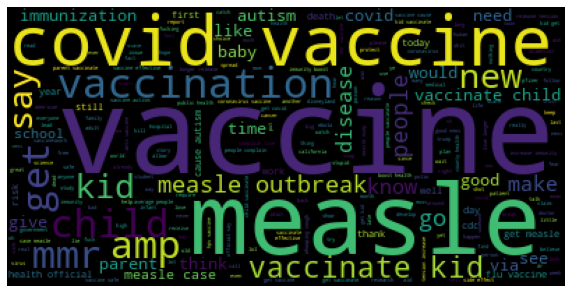

In [ ]:
disp_wordcloud(training_set, 'tweet')

#### Check for imbalanced classes.

In [ ]:
print(len(training_set[training_set.label == 0]))
print(len(training_set[training_set.label == 1]))
print(len(training_set[training_set.label == 2]))

7458
2073
6445


As we can see, the dataset is imbalanced, since the "Anti-Vax" class consists of way less samples than "Neutral" or "Pro-Vax" classes.

#### Have a look at the clean datasets.

In [ ]:
training_set

,tweet,label
0,"[sip, shop, thru, right, marjais, popularnobod...",0
1,"[know, family, covid, vaccine, anytime, soon]",1
2,"[immunization, mandatory, period, oklahoma, wi...",2
3,"[president, obama, speak, favor, vaccination, ...",0
4,"[arizona, monitor, hundred, measle, link, disn...",0
...,...,...
15971,"[believe, anti, vax, nutcase, cause, measle, i...",1
15972,"[feel, parent, vaccinate, kid, measlesoutbreak]",0
15973,"[preschooler, test, measle, simi, valley]",0
15974,"[finance, minister, budget, offer, room, procu...",0


In [ ]:
val_set

,tweet,label
0,"[massive, surge, covid, death, immediately, va...",1
1,"[require, vaccine, school, parent, guardian, c...",0
2,"[two, johnson, county, child, measle]",0
3,"[nv, well, state, good, bad, vaccinate, kid]",2
4,"[nothing, like, kill, w, fear, mt, vaccine, fe...",2
...,...,...
2277,"[number, measle, case, report, cali, year, hig...",0
2278,"[evidence, point, idea, measle, affect, immune...",0
2279,"[vaccinate, kid, two, minute]",2
2280,"[favorite, people, autism, reason, bring, back...",2


## 3. Try to cure imbalanced sets

There are three (3) methods that have been tested in order to reduce the
class imbalance:

* Upsampling by duplicating samples in minor class.
* Downsampling by cutting down samples from the major classes.
* Upsampling by generating synthetic samples from the minor class.

### Let's try upsampling by duplicating the minor class. (Winner method)


In [ ]:
# Separate input features and target
y_train = training_set.label
X_train = training_set.drop('label', axis=1)

# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
neutral = X[X.label==0]
antivax = X[X.label==1]
provax  = X[X.label==2]

# Upsample minority
antivax_upsampled = resample(antivax,
                            replace=True,
                            n_samples=(len(antivax) * 2 + 400),
                            random_state=27)

# Combine majority and upsampled minority
upsampled = pd.concat([neutral, antivax_upsampled, provax])

# Check new class counts
upsampled.label.value_counts()
training_set = upsampled

### Let's downsample the major classes.


In [ ]:
# Separate input features and target
y_train = training_set.label
X_train = training_set.drop('label', axis=1)

# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
neutral = X[X.label==0]
antivax = X[X.label==1]
provax  = X[X.label==2]

# Downsample majority
neutral_downsampled = resample(neutral,
                            replace=False,
                            n_samples=len(antivax)*2 + 400,
                            random_state=27)

provax_downsampled = resample(provax,
                            replace=False, 
                            n_samples=len(antivax)*2 + 500, 
                            random_state=23) 

# Combine classes
downsampled = pd.concat([neutral_downsampled, antivax, provax_downsampled])

# Check new class counts
downsampled.label.value_counts()
training_set = downsampled

### Let's try upsampling by generating synthetic data.

In [ ]:
from imblearn.over_sampling import SMOTE
'''
Generate synthetic data, based on the input dictionary.
The dictionary contains the number of samples needed for 
each class, e.g:
        d = { 0: 7000, 
              1: 5000, 
              2: 6000 }
which means that class 0 must contain 7000 samples, class 1
must contain 5000 samples, etc.
'''
def synthetic_generation(X, y, dict_of_ratios, training_label, target_label):
    X = np.array(list(X.apply(lambda x: np.array(list(x)))))
    y = y.to_numpy()

    sm = SMOTE(dict_of_ratios)
    X, y = sm.fit_resample(X, y)

    for x in X:
        x = list(x)
    X = list(X)
    y = list(y)

    return pd.DataFrame({training_label: X, target_label: y})

## 4. Hyperparameter Tuner

The framework used for the neural network’s tuning is **Optuna**. \\
Optuna
is an open source hyperparameter optimization framework that automates
hyperparameter search.

In [ ]:
class Tuner:
    def __init__(self, objective):
        # Create a maximization study
        self.study = optuna.create_study(direction="maximize")
        self.objective = objective

    def optimize(self):
        # Optimize the given objective by running at most 100 trials
        self.study.optimize(self.objective, n_trials=100, timeout=600)

        pruned_trials = self.study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = self.study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        # Print statistics and return the best performing parameters
        print("Study statistics: ")
        print("  Number of finished trials: ", len(self.study.trials))
        print("  Number of pruned trials: ", len(pruned_trials))
        print("  Number of complete trials: ", len(complete_trials))

        print("Best trial:")
        trial = self.study.best_trial

        print("  Value: ", trial.value)

        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

        return self.study.best_trial.params.items()

## 5. Define a Feed Forward Neural Network
#### *(and some utility functions)*

In [ ]:
'''
    Simple Feed Forward Neural Network.

    Accepts a list of layer units, e.g [10, 4, 5], which corresponds
    to 3 layers consisting of 10, 4 and 5 units respectively.
    
    Also accepts a list of dropouts for each hidden layer. Dropouts can be None. 

    The NN consists of linear layers.
    Sigmoid is being used as an activation function.
'''
class FFNN(nn.Module): 
    def __init__(self, layer_dims, dropouts=None):
        super(FFNN, self).__init__()
        
        layers = []

        for i in range(len(layer_dims) - 2):
            layers.append( nn.Linear(layer_dims[i], layer_dims[i+1]) )
            layers.append( nn.LeakyReLU() )
            if not dropouts is None:
                layers.append(nn.Dropout(p=dropouts[i]))            

        layers.append( nn.Linear(layer_dims[-2], layer_dims[-1]) )

        self.layers = nn.Sequential(*layers)

    def forward(self, x):

        for f in self.layers:
            x = f(x)
        # For CrossEntropyLoss, log_softmax is being automatically used
        # internally, so there's no need to add it here.
        return x

In [ ]:
'''
    Model definition for hyperparameter tuning (optuna).
    The model construction is exactly the same as FFNN.
'''
def define_model(trial, input_size, num_classes):
    # We optimize the number of layers, hidden units and dropout ratio for each layer.
    n_layers = trial.suggest_int("n_layers", 3, 3)
    layers = []

    in_features = input_size # vocab / embedd size
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 150)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Sigmoid())
        
        p = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.6)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, num_classes))

    return nn.Sequential(*layers)

In [ ]:
'''
    ROC curve plotting function
'''
def plot_roc_curve(y_test, y_score, num_classes):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    lw = 2
    plt.figure()
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for all classes")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
'''
    Loss vs Epochs plotting function
'''
def loss_vs_epochs_loss(train_losses, valid_losses, num_epochs):
    plt.plot([i+1 for i in range(num_epochs)], train_losses, label = "Training loss")
    plt.plot([i+1 for i in range(num_epochs)], valid_losses, label = "Validation loss")
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Plot')
    plt.show()

In [ ]:
'''
    Test a model with given parameters.
    The parameters are:
        - Training set
        - Validation set
        - A trainer (BoW, TF-IDF, Embeddings)
        - Layers to build the network with
        - Dropouts
        - Number of epochs (opt.)
'''
def test_model_without_tuning(training_set, val_set, trainer, hidden_layer_dims, dropouts, num_epochs=10):
    train_df, test_df = training_set.copy(deep=True), val_set.copy(deep=True)
    # Shuffle the sets
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

    trainer.fit_train_test(train_df, test_df)

    layer_dims = [trainer.get_input_size()]
    for layer in hidden_layer_dims:
        layer_dims.append(layer)
    layer_dims.append(trainer.get_num_classes())

    ffnn = FFNN(layer_dims, dropouts)

    optimizer = optim.SGD(params=ffnn.parameters(), lr=0.01)
    loss_function = nn.CrossEntropyLoss()

    trainer.train(ffnn, num_epochs, optimizer, loss_function)
    trainer.validate(ffnn)

In [ ]:
'''
    Fine-tune and test a model with the optimal parameters.
    You only have to provide:
        - Training set
        - Validation set
        - A trainer (BoW, TF-IDF, Embeddings)
        - Number of epochs (opt.)
'''
def tune_and_test_model(training_set, val_set, trainer, num_epochs=10):
    train_df, test_df = training_set.copy(deep=True), val_set.copy(deep=True)
    # Shuffle the sets
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

    trainer.fit_train_test(train_df, test_df)

    best_params = Tuner(trainer.objective).optimize()

    layer_dims = [trainer.get_input_size()]
    dropouts = []

    for key, value in best_params:
        if key.find('n_units') != -1:
            layer_dims.append(int(value))
        if key.find('dropout') != -1:
            dropouts.append(float(value))

    layer_dims.append(trainer.get_num_classes())
    
    ffnn = FFNN(layer_dims, dropouts)

    optimizer = optim.Adam(params=ffnn.parameters())
    loss_function = nn.CrossEntropyLoss()

    trainer.train(ffnn, num_epochs, optimizer, loss_function)
    trainer.validate(ffnn)

## 6. Bag of Words (BoW) Model

In [ ]:
'''
    Bag of Words model.

    The input in this model is being transformed to an array with size of 
    vocabulary in the corpus and values that are the frequencies of words 
    in corpus with index being the unique id of the word.
'''
class BoW_Trainer:

    def __init__(self, training_label, target_label):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Save the training and target labels
        self.training_label = training_label
        self.target_label = target_label

    def fit_train_test(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        train_test = pd.concat((train_df, test_df), ignore_index=True)
        # Make the vocabulary
        self.review_dict = self.make_dict(train_test, self.training_label)
        self.vocab_size = len(self.review_dict)
        # Save the number of classes
        self.num_classes = train_test[self.target_label].nunique()

    def get_input_size(self):
        return self.vocab_size

    def get_num_classes(self):
        return self.num_classes

    # Function to return the dictionary
    def make_dict(self, df, tr_label):    
        return corpora.Dictionary(df[tr_label])

    # Function to make bow vector to be used as input to the network
    def make_bow_vector(self, review_dict, sentence):
        vec = torch.zeros(self.vocab_size, dtype=torch.float64, device=self.device)
        for word in sentence:
            vec[review_dict.token2id[word]] += 1
        return vec.view(1, -1).float()

    # Function to get the output tensor
    def make_tensor_target(self, label):
        return torch.tensor([label], dtype=torch.long, device=device)

    def train(self, model, num_epochs, optimizer, loss_function):
        overall_train_loss = []
        overall_valid_loss = []
        # For every epoch
        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            # For every batch
            for batch in np.array_split(self.train_df, 5000):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_bow_vector(self.review_dict, data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                train_loss = train_loss / len(batch)
            overall_train_loss.append(train_loss)
            # Validation of the model.
            model.eval()
            correct = 0
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():

                    data = self.make_bow_vector(self.review_dict, data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    loss = loss_function(output, target)

                    valid_loss += loss.item()

            valid_loss = valid_loss / len(self.test_df)
            overall_valid_loss.append(valid_loss)

            print(f"Epoch {epoch+1}: Train loss: {str(train_loss)[:5]} | Valid loss: {str(valid_loss)[:5]}")

        # Plot loss vs epochs diagram
        loss_vs_epochs_loss(overall_train_loss, overall_valid_loss, num_epochs)

    # Validate the model and print a classification report along with the ROC curve
    def validate(self, model):

        y_score = []
        y_test = []
        predictions = []
        original_labels = []
        with torch.no_grad():
            for idx, (data, target) in self.test_df.iterrows():    
                data = self.make_bow_vector(self.review_dict, data).to(self.device)
                probs = model(data)
                
                y_score.append(probs.numpy().flatten())
                y_test.append(target)

                predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
                original_labels.append(self.make_tensor_target(target).cpu().numpy()[0])
        print(classification_report(original_labels, predictions))
        
        y_score = np.array(y_score)
        y_test = label_binarize(np.array(y_test), classes=[i for i in range(self.num_classes)] )
        plot_roc_curve(y_test, y_score, self.num_classes)

    # Objective function used for hyperparameter tuning
    def objective(self, trial):

        num_epochs = 15

        # Generate the model.
        model = define_model(trial, self.vocab_size, self.num_classes).to(self.device)

        # Generate the learning rates.
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        # Define best performing optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()

        # Training of the model.
        for epoch in range(num_epochs):
            model.train()
            for batch in np.array_split(self.train_df, 5000):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_bow_vector(self.review_dict, data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

            # Validation of the model.
            model.eval()
            y_pred = []
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():

                    data = self.make_bow_vector(self.review_dict, data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    # Get the index of the max log-probability.
                    y_pred.append(output.argmax(dim=1, keepdim=True))

            # Calculate the f1 score (we're trying to maximize it)
            score = f1_score(self.test_df[self.target_label], np.array(y_pred), labels=self.train_df[self.target_label].unique(), average='weighted')

            trial.report(score, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return score

### Try tuning the set
The following code cell fine-tunes the model and trains it for 10 epochs.

[I 2021-12-22 14:03:46,612] A new study created in memory with name: no-name-1e4c4a5a-c722-4581-be52-9e65f9cb85dc
[I 2021-12-22 15:20:19,442] Trial 0 finished with value: 0.6964931648136566 and parameters: {'n_layers': 3, 'n_units_l0': 28, 'dropout_l0': 0.49966244159041767, 'n_units_l1': 68, 'dropout_l1': 0.5245591749122054, 'n_units_l2': 23, 'dropout_l2': 0.3814984291477838, 'lr': 0.002199005961790182}. Best is trial 0 with value: 0.6964931648136566.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.6964931648136566
  Params: 
    n_layers: 3
    n_units_l0: 28
    dropout_l0: 0.49966244159041767
    n_units_l1: 68
    dropout_l1: 0.5245591749122054
    n_units_l2: 23
    dropout_l2: 0.3814984291477838
    lr: 0.002199005961790182
Epoch 1: Train loss: 1.514 | Valid loss: 0.704
Epoch 2: Train loss: 2.055 | Valid loss: 0.718
Epoch 3: Train loss: 1.921 | Valid loss: 0.733
Epoch 4: Train loss: 1.366 | Valid loss: 0.744
Epoch 5: Train loss: 1.390 | Valid loss: 0.766
Epoch 6: Train loss: 0.827 | Valid loss: 0.807
Epoch 7: Train loss: 0.956 | Valid loss: 0.810
Epoch 8: Train loss: 1.163 | Valid loss: 0.873
Epoch 9: Train loss: 1.300 | Valid loss: 0.849
Epoch 10: Train loss: 1.335 | Valid loss: 0.867


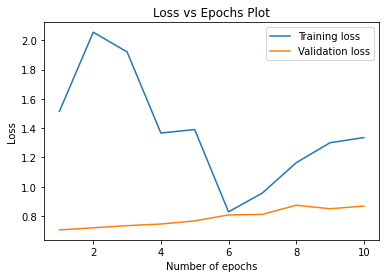

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1065
           1       0.42      0.52      0.46       296
           2       0.67      0.72      0.69       921

    accuracy                           0.69      2282
   macro avg       0.64      0.65      0.64      2282
weighted avg       0.71      0.69      0.70      2282



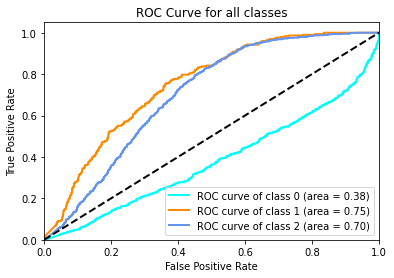

In [ ]:
trainer = BoW_Trainer('tweet', 'label')
epochs = 10
tune_and_test_model(training_set, val_set, trainer, epochs)

### Pass your own parameters
Don't want to spend time tuning? Train it on your own parameters!

Epoch 1: Train loss: 1.013 | Valid loss: 0.735
Epoch 2: Train loss: 0.885 | Valid loss: 0.674
Epoch 3: Train loss: 0.801 | Valid loss: 0.685
Epoch 4: Train loss: 1.064 | Valid loss: 0.674
Epoch 5: Train loss: 0.860 | Valid loss: 0.668
Epoch 6: Train loss: 0.584 | Valid loss: 0.687
Epoch 7: Train loss: 0.696 | Valid loss: 0.704
Epoch 8: Train loss: 0.428 | Valid loss: 0.680
Epoch 9: Train loss: 1.297 | Valid loss: 0.704
Epoch 10: Train loss: 0.795 | Valid loss: 0.742


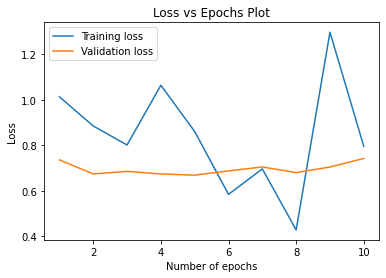

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1065
           1       0.46      0.65      0.54       296
           2       0.69      0.74      0.71       921

    accuracy                           0.71      2282
   macro avg       0.67      0.70      0.67      2282
weighted avg       0.74      0.71      0.72      2282



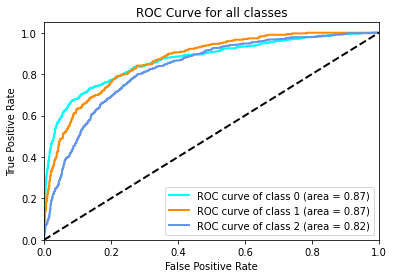

In [ ]:
trainer = BoW_Trainer('tweet', 'label')
hidden_layer_dims = [300, 180, 20]
dropouts = [0.7, 0.5, 0.0]
epochs = 10
test_model_without_tuning(training_set, val_set, trainer, hidden_layer_dims, dropouts, epochs)

## 7. TF-IDF Model


In [ ]:
'''
    TF-IDF model.

    The input in this model is being provided by TF-IDF vectorizer.
'''
class TF_IDF_Trainer:

    def __init__(self, training_label, target_label):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.training_label = training_label
        self.target_label = target_label

    # Transformation based on TF-IDF vectorizer
    def tfidf_transform(self):
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                        stop_words=stop_words,
                                        norm=None, min_df=0.005, max_df=0.85)
        
        self.train_df[self.training_label] = self.train_df[self.training_label].apply(lambda x: ' '.join(x))
        self.test_df[self.training_label] = self.test_df[self.training_label].apply(lambda x: ' '.join(x))
        # Vectorize training and testing set.
        # We use fit_transform() on the training set, in order to learn 
        # the parameters of scaling on the training set and in the same
        # time we scale the train data. We only use transform() on 
        # the testing set, because we use the scaling paramaters learned 
        # on the train data to scale the test data.
        self.train_df[self.training_label] = vectorizer.fit_transform(self.train_df[self.training_label])
        self.test_df[self.training_label] = vectorizer.transform(self.test_df[self.training_label])

        self.train_df[self.training_label] = self.train_df[self.training_label].apply(lambda x: x.todense())
        self.test_df[self.training_label] = self.test_df[self.training_label].apply(lambda x: x.todense())

        dims = self.train_df[self.training_label][0].shape
        self.vocab_size = dims[0] * dims[1]

    def fit_train_test(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        self.num_classes = self.train_df[self.target_label].nunique()
        self.tfidf_transform()

    def get_input_size(self):
        return self.vocab_size

    def get_num_classes(self):
        return self.num_classes

    # Function to return the dictionary
    def make_dict(self, df, tr_label):    
        return corpora.Dictionary(df[tr_label])

    # Function to make tfidf vector to be used as input to network
    def make_tfidf_vector(self, sentence):
        return torch.tensor(sentence, dtype=torch.float64, device=self.device).view(1, -1).float()

    # Function to get the output tensor
    def make_tensor_target(self, label):
        return torch.tensor([label], dtype=torch.long, device=device)

    def train(self, model, num_epochs, optimizer, loss_function):
        overall_train_loss = []
        overall_valid_loss = []
        # Training of the model.
        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            for batch in np.array_split(self.train_df, 1000):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_tfidf_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                train_loss = train_loss / len(batch)
            overall_train_loss.append(train_loss)

            # Validation of the model.
            model.eval()
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():

                    data = self.make_tfidf_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    loss = loss_function(output, target)

                    valid_loss += loss.item()

            valid_loss = valid_loss / len(self.test_df)
            overall_valid_loss.append(valid_loss)

            print(f"Epoch {epoch + 1} : Train loss {str(train_loss)[:4]} | Valid loss {str(valid_loss)[:4]}")

        loss_vs_epochs_loss(overall_train_loss, overall_valid_loss, num_epochs)
        
    def validate(self, model):

        y_score = []
        y_test = []
        predictions = []
        original_labels = []
        with torch.no_grad():
            for idx, (data, target) in self.test_df.iterrows():    
                data = self.make_tfidf_vector(data).to(self.device)
                probs = model(data)

                y_score.append(probs.numpy().flatten())
                y_test.append(target)

                predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
                original_labels.append(self.make_tensor_target(target).cpu().numpy()[0])
        print(classification_report(original_labels, predictions))

        y_score = np.array(y_score)
        y_test = label_binarize(np.array(y_test), classes=[i for i in range(self.num_classes)] )
        plot_roc_curve(y_test, y_score, self.num_classes)

    # Objective function used for hyperparameter tuning
    def objective(self, trial):

        num_epochs = 50

        # Generate the model.
        model = define_model(trial, self.embeddings_dim, self.num_classes).to(self.device)

        # Generate the learning rates.
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        # Define best performing optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()

        # Training of the model.
        for epoch in range(num_epochs):
            model.train()
            for batch in np.array_split(self.train_df, 1000):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_tfidf_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

            # Validation of the model.
            model.eval()
            score = 0
            y_pred =[]
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():
                    data = self.make_tfidf_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    # Get the index of the max log-probability.
                    y_pred.append(output.argmax(dim=1, keepdim=True))

            score = f1_score(self.test_df[self.target_label], np.array(y_pred), labels=self.train_df[self.target_label].unique(), average='weighted')
            trial.report(score, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return score

### Run TF-IDF NN model.
*Hint*: This will take a very long time....

In [ ]:
trainer = TF_IDF_Trainer('tweet', 'label')
hidden_layer_dims = [200, 150, 50]
dropouts = [0.8, 0.5, 0.1]
num_epochs = 10
test_model_without_tuning(training_set, val_set, trainer, hidden_layer_dims, dropouts, num_epochs)

## 8. Word Embeddings Model

In [ ]:
'''
    Word Embeddings model.
'''
class Embeddings_Trainer:

    def __init__(self, training_label, target_label, pre_trained_vectors, emb_dim=200):
        # Set up the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Save the embeddings dimension and the pretrained vectors
        self.embeddings_dim = emb_dim
        self.pretrained_vectors = pre_trained_vectors
        # Save the training and target labels
        self.training_label = training_label
        self.target_label = target_label
        self.num_classes = 0

    def get_input_size(self):
        return self.embeddings_dim

    def get_num_classes(self):
        return self.num_classes

    # Function to make embeddings tensor to be used as input to network
    def make_word_emb_vector(self, sentence):
        return torch.tensor(sentence, dtype=torch.float64, device=self.device).view(1, -1).float()

    # Function to get the output tensor
    def make_tensor_target(self, label):
        return torch.tensor([label], dtype=torch.long, device=self.device)

    # Returns a document-vectors array 
    def get_doc_vectors(self, df):
        
        def get_doc_mean(doc):
            result = np.zeros((len(doc), self.embeddings_dim))
            for i, w in enumerate(doc):
                if w in self.pretrained_vectors:
                    result[i] = self.pretrained_vectors[w]
                else:
                    result[i] = self.pretrained_vectors['unk']
            return np.mean(result, axis = 0)

        # Return the mean vectors of every sentence
        result = list(get_doc_mean(doc) for doc in df)
        if len(result) == 0:
            return None
        return result

    def fit_train_test(self, train_df, test_df):

        self.num_classes = train_df[self.target_label].nunique()

        train_df[self.training_label] = self.get_doc_vectors(train_df[self.training_label])
        test_df[self.training_label] = self.get_doc_vectors(test_df[self.training_label])

        self.train_df = train_df
        self.test_df = test_df

    def train(self, model, num_epochs, optimizer, loss_function):

        overall_train_loss = []
        overall_valid_loss = []
        # Training of the model.
        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            for batch in np.array_split(self.train_df, 100):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                train_loss = train_loss / len(batch)
            overall_train_loss.append(train_loss)

            # Validation of the model.
            model.eval()
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():

                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    loss = loss_function(output, target)

                    valid_loss += loss.item()

            valid_loss = valid_loss / len(self.test_df)
            overall_valid_loss.append(valid_loss)

            if epoch % 5 == 0:
                print(f"Epoch {epoch} : Train loss {str(train_loss)[:4]} | Valid loss {str(valid_loss)[:4]}")

        loss_vs_epochs_loss(overall_train_loss, overall_valid_loss, num_epochs)
        
    def validate(self, model):

        y_score = []
        y_test = []
        predictions = []
        original_labels = []
        with torch.no_grad():
            for idx, (data, target) in self.test_df.iterrows():    
                data = self.make_word_emb_vector(data).to(self.device)
                probs = model(data)

                y_score.append(probs.numpy().flatten())
                y_test.append(target)

                predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
                original_labels.append(self.make_tensor_target(target).cpu().numpy()[0])
        print(classification_report(original_labels, predictions))

        y_score = np.array(y_score)
        y_test = label_binarize(np.array(y_test), classes=[i for i in range(self.num_classes)] )
        plot_roc_curve(y_test, y_score, self.num_classes)

    # Objective function used for hyperparameter tuning
    def objective(self, trial):

        num_epochs = 15

        # Generate the model.
        model = define_model(trial, self.embeddings_dim, self.num_classes).to(self.device)

        # Generate the learning rates.
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        # Define best performing optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()

        # Training of the model.
        for epoch in range(num_epochs):
            model.train()
            for batch in np.array_split(self.train_df, 1000):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()
                    optimizer.step()

            # Validation of the model.
            model.eval()
            score = 0
            y_pred =[]
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():
                    
                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    # Get the index of the max log-probability.
                    y_pred.append(output.argmax(dim=1, keepdim=True))

            score = f1_score(self.test_df[self.target_label], np.array(y_pred), labels=self.train_df[self.target_label].unique(), average='weighted')
        
            trial.report(score, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return score

### Download GloVe's Tweeter dataset.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-12-16 12:59:11--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-16 12:59:11--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.19MB/s    in 4m 48s  

2021-12-16 13:03:59 (5.04 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:
!unzip -q glove.twitter.27B.zip
EMBEDDINGS_DIM = 200
pre_trained_vectors = {}
glove_embeddings_path = 'glove.twitter.27B.200d.txt'
f = open(glove_embeddings_path, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    pre_trained_vectors[word] = coefs
f.close()

### Run a tuning session on Word Embeddings model

[I 2021-12-16 14:24:51,700] A new study created in memory with name: no-name-223aa8df-e0b7-4cda-941a-8eb8393f85f1
[I 2021-12-16 14:31:13,119] Trial 0 finished with value: 0.6730850890963533 and parameters: {'n_layers': 3, 'n_units_l0': 82, 'dropout_l0': 0.3785649360498019, 'n_units_l1': 100, 'dropout_l1': 0.08071670510541899, 'n_units_l2': 5, 'dropout_l2': 0.06761639969595132, 'lr': 0.0006707240831081346}. Best is trial 0 with value: 0.6730850890963533.
[I 2021-12-16 14:36:31,513] Trial 1 finished with value: 0.6905003572146906 and parameters: {'n_layers': 2, 'n_units_l0': 53, 'dropout_l0': 0.3320662670152818, 'n_units_l1': 107, 'dropout_l1': 0.5244422504874238, 'lr': 0.0016766050696703132}. Best is trial 1 with value: 0.6905003572146906.


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  0.6905003572146906
  Params: 
    n_layers: 2
    n_units_l0: 53
    dropout_l0: 0.3320662670152818
    n_units_l1: 107
    dropout_l1: 0.5244422504874238
    lr: 0.0016766050696703132
Epoch 0 : Train loss 0.88 | Valid loss 0.79
Epoch 5 : Train loss 0.82 | Valid loss 0.75
Epoch 10 : Train loss 0.71 | Valid loss 0.74
Epoch 15 : Train loss 0.70 | Valid loss 0.74
Epoch 20 : Train loss 0.63 | Valid loss 0.74
Epoch 25 : Train loss 0.60 | Valid loss 0.76
Epoch 30 : Train loss 0.63 | Valid loss 0.76
Epoch 35 : Train loss 0.57 | Valid loss 0.78
Epoch 40 : Train loss 0.55 | Valid loss 0.79
Epoch 45 : Train loss 0.57 | Valid loss 0.84


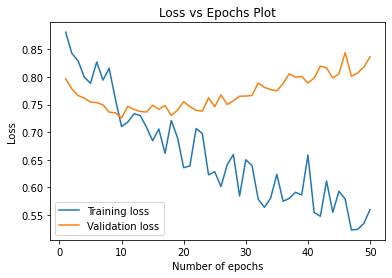

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1065
           1       0.38      0.56      0.46       296
           2       0.67      0.66      0.67       921

    accuracy                           0.67      2282
   macro avg       0.62      0.65      0.63      2282
weighted avg       0.70      0.67      0.68      2282



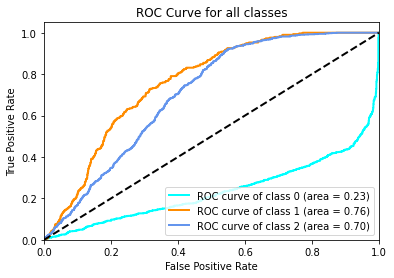

In [ ]:
trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
num_epochs = 50
tune_and_test_model(training_set, val_set, trainer, num_epochs)

### Pass your own parameters

Epoch 0 : Train loss 0.96 | Valid loss 0.80
Epoch 5 : Train loss 0.89 | Valid loss 0.74
Epoch 10 : Train loss 0.81 | Valid loss 0.73
Epoch 15 : Train loss 0.79 | Valid loss 0.72
Epoch 20 : Train loss 0.74 | Valid loss 0.72
Epoch 25 : Train loss 0.67 | Valid loss 0.72
Epoch 30 : Train loss 0.70 | Valid loss 0.72
Epoch 35 : Train loss 0.63 | Valid loss 0.73
Epoch 40 : Train loss 0.62 | Valid loss 0.73
Epoch 45 : Train loss 0.68 | Valid loss 0.73


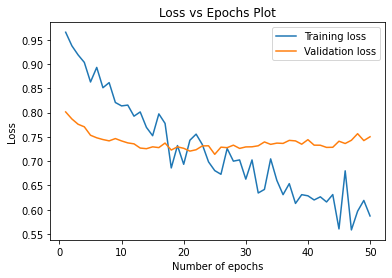

              precision    recall  f1-score   support

           0       0.81      0.72      0.77      1065
           1       0.46      0.51      0.49       296
           2       0.66      0.72      0.69       921

    accuracy                           0.70      2282
   macro avg       0.65      0.65      0.65      2282
weighted avg       0.71      0.70      0.70      2282



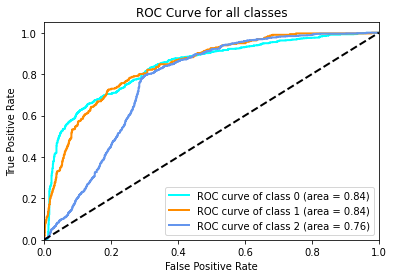

In [ ]:
trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
hidden_layer_dims = [150, 125, 10]
dropouts = [0.6, 0.3, 0.0]
num_epochs = 50
test_model_without_tuning(training_set, val_set, trainer, hidden_layer_dims, dropouts, num_epochs)

## 9. Results
Based on all the testing, tuning and experimenting, the **overall best performing model** is a Word Embeddings Feed Forward Neural Network consisting of:

* GloVe's pretrained 200-dimensional twitter vectors.
* An input layer consisting of 200 units.
* An output layer consisting of 3 units.
* 3 hidden layers consisting of 150, 125 and 10 units respectively.
* Sigmoid activation function to the hidden layers.
* 2 dropout layers having 60\% and 30\% dropout probabilities respectively.
* Adam optimizer.
* Cross Entropy loss function.
* 30 epochs of training.

## 10. Experiment with **your** test set!

In [ ]:
training_set_path = r'YOUR TRAINING SET LINK GOES HERE'
test_set_path     = r'YOUR TEST SET LINK GOES HERE'

training_set = pd.read_csv(training_set_path, index_col=0)
test_set = pd.read_csv(test_set_path, index_col=0)

**WARNING**: In order for this section to work, you'll have to fully execute sections:
* 1 (Imports and initializations *without linking Google Drive*)
* 2 (Preprocessing)
* 3.1 Upsampling by duplicating the minor class
* 4 (Hyperparameter Tuner)
* 5 (Define a Feed Forward Neural Network)
* 8.1 (Embeddings class)
* 8.2 (Download GloVe's Tweeter dataset)

In [ ]:
# Run this code cell!
trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
hidden_layer_dims = [150, 125, 10]
dropouts = [0.6, 0.3, 0.0]
num_epochs = 30
test_model_without_tuning(training_set, val_set, trainer, hidden_layer_dims, dropouts, num_epochs)

## 11. Sources 

* [Deal With Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

* [Optuna](https://optuna.org/#code_PyTorch)

* [Log-Softmax vs Softmax](https://deepdatascience.wordpress.com/2020/02/27/log-softmax-vs-softmax/)

* [Loss functions v1](https://www.machinecurve.com/index.php/2021/07/19/how-to-use-pytorch-loss-functions/)

* [Loss functions v2](https://rohanvarma.me/Loss-Functions/)

* [Optimizing](https://ruder.io/optimizing-gradient-descent/index.html)

* [Notes in Neural Networks](https://cs231n.github.io/neural-networks-1/)